In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dropout, LeakyReLU, UpSampling2D
from tensorflow.keras.layers import Concatenate, Add, Dense
from tensorflow.keras.models import Model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8584693197814480955
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5736300544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2919383275644050559
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:0a:00.0, compute capability: 8.6"
]


In [2]:
# These values are arbitrarily chosen until network is finalised
batch_size = 16
depth = 16
categories = 2
epochs = 5
n = 192
m = 256

In [3]:
# Building the Model
def conv3x3(input_layer, filters, kernel_size=(3,3), strides=(1,1)):
    conv1 = Conv2D(filters, kernel_size, strides, padding="same", kernel_initializer="he_normal")(input_layer)
    leaky = LeakyReLU(0.01)(conv1)
    # maybe do a batch norm here too?
    # https://edstem.org/au/courses/6584/discussion/652021
    return leaky

def context_module(input_layer, filters):
    conv1 = conv3x3(input_layer, filters)
    drop1 = Dropout(0.3)(conv1)
    return conv3x3(drop1, filters)

def upsampling_module(input_layer, filters):
    upsample1 = UpSampling2D(size=(2,2))(input_layer)
    return conv3x3(upsample1, filters)

def localisation_module(input_layer, filters):
    conv1 = conv3x3(input_layer, filters)
    return conv3x3(conv1, filters, kernel_size=(1,1))

def build_model(input_shape, depth):
    inputs = Input(input_shape)
    
    # First Context Level
    conv1 = conv3x3(inputs, depth)
    context1 = context_module(conv1, depth)
    concat1 = Add()([conv1, context1])
    
    # Second Context Level
    conv2 = conv3x3(concat1, depth*2, strides=(2,2))
    context2 = context_module(conv2, depth*2)
    concat2 = Add()([conv2, context2])
    
    # Third Context Level
    conv3 = conv3x3(concat2, depth*4, strides=(2,2))
    context3 = context_module(conv3, depth*4)
    concat3 = Add()([conv3, context3])
    
    # Fourth Context Level
    conv4 = conv3x3(concat3, depth*8, strides=(2,2))
    context4 = context_module(conv4, depth*8)
    concat4 = Add()([conv4, context4])
    
    # Fifth (Last) Context Level
    conv5 = conv3x3(concat4, depth*16, strides=(2,2))
    context5 = context_module(conv5, depth*16)
    concat5 = Add()([conv5, context5])

    # Upsampling happens at this level too (bottom level)
    upsample1 = upsampling_module(concat5, depth*8)
    save1 = Concatenate()([upsample1, concat4])    
    localise1 = localisation_module(save1, depth*8)
    
    upsample2 = upsampling_module(localise1, depth*4)
    save2 = Concatenate()([upsample2, concat3])
    localise2 = localisation_module(save2, depth*4)
    
    seg1 = conv3x3(localise2, 16, kernel_size=(1,1))
    seg1 = UpSampling2D(size=(2,2))(seg1)
    
    upsample3 = upsampling_module(localise2, depth*2)
    save3 = Concatenate()([upsample3, concat2])
    localise3 = localisation_module(save3, depth*2)
    
    seg2 = conv3x3(localise3, 16, kernel_size=(1,1))
    seg2 = Add()([seg2, seg1])
    seg2 = UpSampling2D(size=(2,2))(seg2)
    
    upsample4 = upsampling_module(localise3, depth)
    save4 = Concatenate()([upsample4, concat1])
    
    conv_last = conv3x3(save4, depth*2)
    seg3 = conv3x3(conv_last, depth, kernel_size=(1,1))
    seg3 = Add()([seg3, seg2])
    
    softmax = Conv2D(1, kernel_size=(1,1), padding="same", activation="softmax")(seg3)
    
    sigmoid = Dense(1, activation="sigmoid")(softmax)
    
    outputs = sigmoid
    model = Model(inputs, outputs)
    model.summary()
    
    return model 

In [4]:
model = build_model(input_shape=(n,m,1), depth=depth)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 192, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 16) 2320        leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [5]:
def process_images(path, segmentation):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory = path, 
        labels=None,
        label_mode = 'binary',
        batch_size = batch_size,
        validation_split = 0.1,
        subset=segmentation,
        image_size = (n,m),
        color_mode = 'grayscale',
        shuffle = True,
        seed = 45820188
    )

In [6]:
X_train_ds = process_images("C:\ISIC Dataset\Full Set\ISIC2018_Task1-2_Training_Input_x2", "training")
y_train_ds = process_images("C:\ISIC Dataset\Full Set\ISIC2018_Task1_Training_GroundTruth_x2", "training")

X_test_ds = process_images("C:\ISIC Dataset\Full Set\ISIC2018_Task1-2_Training_Input_x2", "validation")
y_test_ds = process_images("C:\ISIC Dataset\Full Set\ISIC2018_Task1_Training_GroundTruth_x2", "validation")

# X_train_ds = process_images("C:\ISIC Dataset\Smaller\Train", "training")
# y_train_ds = process_images("C:\ISIC Dataset\Smaller\Seg", "training")

# X_test_ds = process_images("C:\ISIC Dataset\Smaller\Train", "validation")
# y_test_ds = process_images("C:\ISIC Dataset\Smaller\Seg", "validation")


X_train = tf.concat([x for x in X_train_ds], axis=0)
y_train = tf.concat([x for x in y_train_ds], axis=0)
X_test = tf.concat([x for x in X_test_ds], axis=0)
y_test = tf.concat([x for x in y_test_ds], axis=0)

Found 2594 files belonging to 1 classes.
Using 2335 files for training.
Found 2594 files belonging to 1 classes.
Using 2335 files for training.
Found 2594 files belonging to 1 classes.
Using 259 files for validation.
Found 2594 files belonging to 1 classes.
Using 259 files for validation.


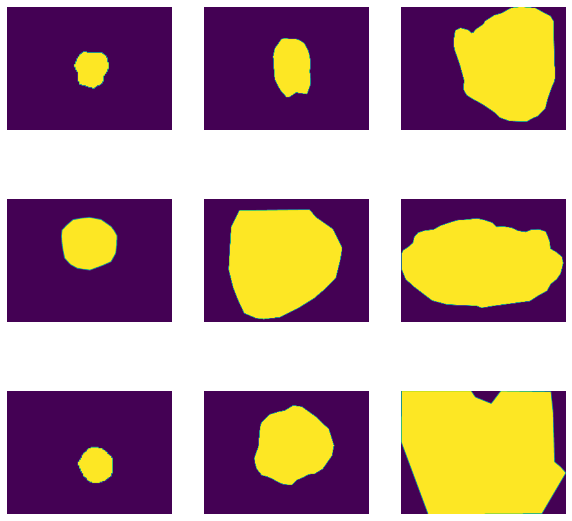

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images in y_test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test))

Epoch 1/5
146/146 [==============================] - 20s 103ms/step - loss: 26.5277 - accuracy: 0.7815 - val_loss: 18.0174 - val_accuracy: 0.7899
Epoch 2/5
146/146 [==============================] - 13s 89ms/step - loss: 11.0999 - accuracy: 0.7815 - val_loss: 3.2508 - val_accuracy: 0.7899
Epoch 3/5
146/146 [==============================] - 13s 90ms/step - loss: -4.3145 - accuracy: 0.1409 - val_loss: -11.6176 - val_accuracy: 2.2780e-06
Epoch 4/5
146/146 [==============================] - 13s 91ms/step - loss: -19.6909 - accuracy: 3.1628e-06 - val_loss: -26.3919 - val_accuracy: 2.2780e-06
Epoch 5/5
146/146 [==============================] - 13s 89ms/step - loss: -35.0413 - accuracy: 3.1628e-06 - val_loss: -41.1186 - val_accuracy: 2.2780e-06


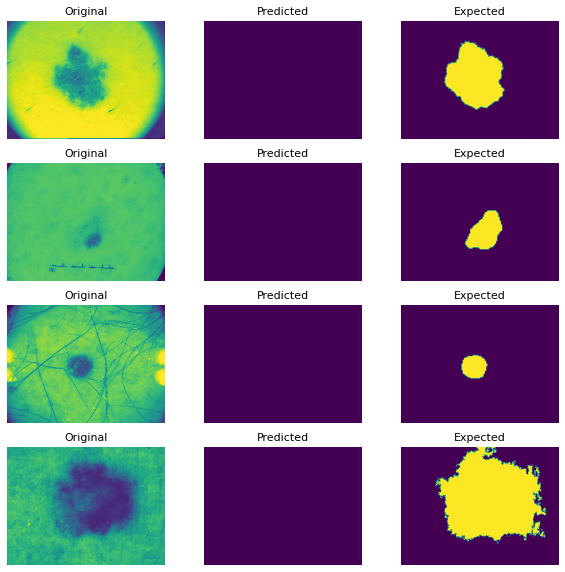

In [10]:
import matplotlib.pyplot as plt
prediction = model.predict(X_test)
plt.figure(figsize=(10, 10))
n = 4
for i in range(n):
    plt.subplot(n, 3, i*3+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title("Original", size=11)
    plt.subplot(n, 3, i*3+2)
    plt.imshow(prediction[i])
    plt.axis('off')
    plt.title("Prediction", size=11)
    plt.subplot(n, 3, i*3+3)
    plt.imshow(y_test[i])
    plt.axis('off')
    plt.title("Expected", size=11)
plt.show()